<h1><center><u>Title placeholder</u></center></h1>

<h1><center><u>Introduction</u></center></h1>

<h3>Players Dataset Description</h3>

| Variable | Type   | Missing Values | Description   | Potential Issues    |
|----------|--------|----------------|---------------|---------------------|
| experience| Character (categorical)| 0 | Player's self-reported experience level:<br>Pro, Veteran, Amateur, Beginner, or Regular | Experience level does not seem to correlate with subscription status. |
| subscribe| Logical (categorical)  | 0 | Indicates whether the player has an active subscription: True or False  | There is a class imbalance in the subscribe variable. |
| hashedEmail| Character (categorical)| 0 | Anonymized, unique identifier for each player’s email address | The variable names and hashedEmails will not help in the analysis of data. |
| played_hours | Double (numerical) | 0 | Total cumulative hours the player has played to one decimal place| Many users logged very little hours played on the game, causing significant outliers.<br>Does played_hours correspond to hours played in lifetime or hours played in a single game/sitting? |
| name | Character (categorical)| 0 | The player's first name | N/A |
| gender | Character (categorical)| 0 | The player's self-reported gender:<br>Male, Female, Agender, Nonbinary, Two-spirited, Prefer not to say, or Other | Variables like Age, gender, and experience are self-reported and may be inaccurate.<br>If K-NN classification with the gender variable is used, variable type needs to be converted.  |
| Age| Double (numerical)| 2 | The player's age in years | There are 2 missing values in the Age column<br>Extreme outliers, some players have values near zero. |


<h1><center><u>Methods and Results</u></center></h1>

<h3>Reading in the Data</h3>

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [22]:
players_raw <- read.csv("https://raw.githubusercontent.com/bhallasaachi/dsci-100-2025w1-Saachi-group-45/refs/heads/main/players.csv")
players_initial <- players_raw|>
head(10)
players_initial

,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
7,Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
8,Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
9,Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47


<h3>Summary Stats</h3>

In [3]:
players_mean <- players_raw |>
select(Age, played_hours)|>
map(mean, na.rm = TRUE)
players_mean

subscribe_percentage <- nrow(players_raw)
players_raw |>
  group_by(subscribe) |>
  summarize(
    count = n(),
  )

$Age
[1] 21.1

$played_hours
[1] 3.5

subscribe,count
<lgl>,<int>
FALSE,2
TRUE,8


<h3>Wrangling the Data for Analysis</h3>

In [4]:
players <- 
select(players_raw, subscribe, played_hours, Age) |>
mutate( subscribe = as_factor(subscribe))
players

# players <- 
# select(players_raw, subscribe, played_hours, gender, Age) |>
# mutate(gender = as_factor(gender), subscribe = as_factor(subscribe))
# players

# library(fastDummies)
# players_dummy <- dummy_cols(players, select_columns = 'gender')

#selected variables needed for analysis
#changed gender and subscribe from character to factor type
#**********still need to create a dummy variable for gender



,subscribe,played_hours,Age
,<fct>,<dbl>,<int>
1,TRUE,30.3,9
2,TRUE,3.8,17
3,FALSE,0.0,17
4,TRUE,0.7,21
5,TRUE,0.1,21
6,TRUE,0.0,17
7,TRUE,0.0,19
8,FALSE,0.0,21
9,TRUE,0.1,47


<h3>Visualizations</h3>

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


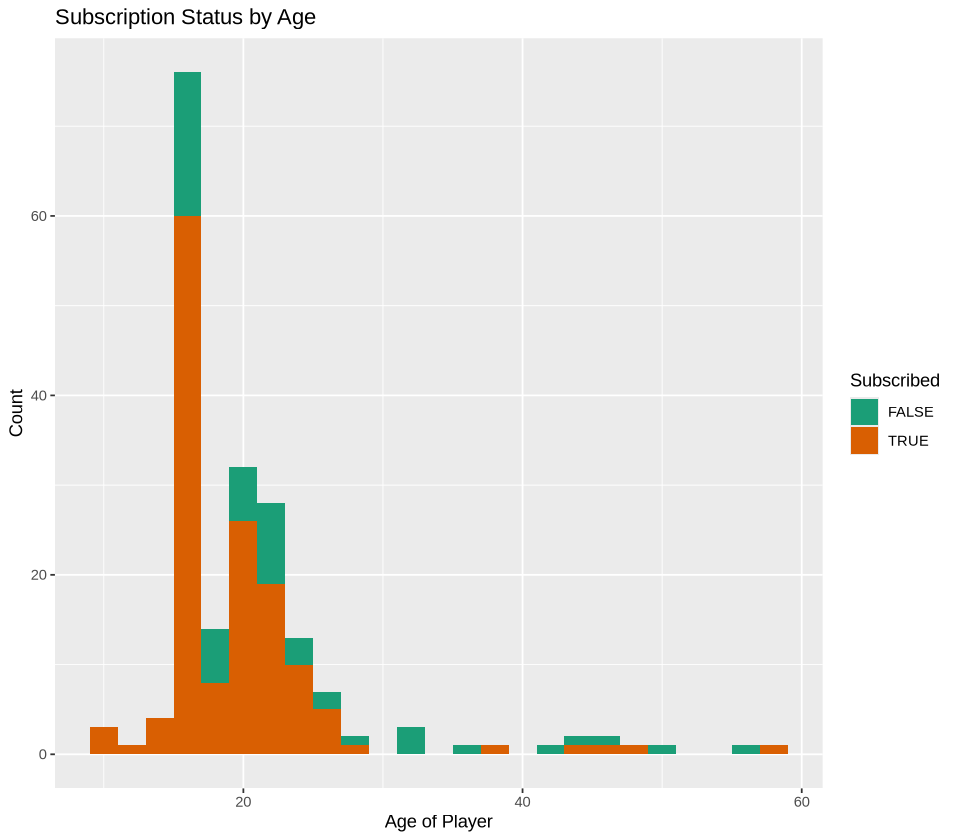

In [37]:
ggplot(players_raw, aes(x = Age, fill = subscribe)) +
  geom_histogram(binwidth = 2) +
  scale_fill_brewer(palette = "Dark2") +
  labs(title = "Subscription Status by Age",
       x = "Age of Player",
       y = "Count",
       fill = "Subscribed")

options(repr.plot.width = 8, repr.plot.height = 7)

<h3>K-nn Classification</h3>

In [6]:
library(themis)
library(tidymodels)


set.seed(1)


players_split <- initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

# players_proportions <- players_train |>
#                       group_by(subscribe) |>
#                       summarize(n = n()) |>
#                       mutate(percent = 100*n/nrow(players_train))

# players_proportions

players_recipe <- recipe (subscribe ~ ., data = players_train) |>
step_impute_mean(all_predictors()) |>
# step_upsample(subscribe, over_ratio = 1, skip = TRUE) |>
step_scale(all_predictors()) |>
step_center(all_predictors()) 


players_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

players_vfold <- vfold_cv(players_train, v = 10, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

players_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- players_results |>
  filter(.metric == "accuracy")

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

players_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")


players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec_tuned) |>
  fit(data = players_train)
players_fit

players_predictions<- predict(players_fit, players_test) |>
  bind_cols(players_test)

players_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")


Loading required package: recipes


Attaching package: ‘recipes’


The following object is masked from ‘package:stringr’:

    fixed


The following object is masked from ‘package:stats’:

    step


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages



ERROR: [1m[33mError[39m in `vfold_cv()`:[22m
[33m![39m The number of rows is less than `v = 10`


<h1><center><u>Discussion</u></center></h1>

<h1><center><u>References</u></center></h1>